# EE 519 — Speech AI
## HW-1 | Notebook 1: Recording, Sampling & Quantization

**Student Name:**  
**USC ID:**  
**Date:**  

---

### Learning Objectives
By completing this notebook, you will:
- Understand the transition from continuous speech to digital signals
- Explore the effects of sampling rate and quantization
- Connect visual distortions to perceptual changes
- Develop intuition for minimum requirements in speech processing

> ⚠️ **Important**
> - All answers (code + explanations) must be written **inside this notebook**
> - Do **not** delete questions or prompts
> - Clearly label all plots (title, axes, units)
> - Audio must be playable inline


### Grading (Notebook 1 — 20 points)

| Component | Points |
|---|---:|
| Correct signal recording & handling | 4 |
| Sampling experiments & plots | 5 |
| Quantization experiments & plots | 5 |
| Observations & explanations | 4 |
| Clarity & organization | 2 |

> We grade **understanding and reasoning**, not perfection.


---

# 0. Setup

This notebook is designed to work with **your own recordings**. You will record:
1. A sustained vowel (≈3 seconds), e.g., `/a/`, `/i/`, or `/u/`
2. A spoken sentence (≈3–6 seconds), e.g., **“I am taking a speech AI course.”**

## File requirements
- WAV format recommended
- Mono (one channel) preferred
- Keep filenames simple (no spaces), e.g.:
  - `vowel.wav`
  - `sentence.wav`

Place your files in the same folder as this notebook, or update the path variables below.


In [1]:
# TODO: Load required libraries
# Recommended: numpy, scipy, matplotlib
# Optional (helpful): soundfile, librosa, IPython.display

import numpy as np
import matplotlib.pyplot as plt

# If you want inline audio playback:
from IPython.display import Audio, display


In [2]:
# TODO: Set paths to your recordings
VOWEL_PATH = "vowel.wav"
SENTENCE_PATH = "sentence.wav"


In [ ]:
import sounddevice as sd
import soundfile as sf
fs = 16000
duration = 3
print("recording vowel: A sustained vowel `/a/`")
vowel_audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()
print("saving vowel")
sf.write(VOWEL_PATH, vowel_audio, fs)



recording vowel: A sustained vowel `/a/`
saving vowel


In [ ]:
print("recording sentence: A spoken sentence: I am taking a speech AI course.")
sentence_audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()
print("saving sentence")
sf.write(SENTENCE_PATH, sentence_audio, fs)
print("recordings saved")

recording sentence: A spoken sentence: I am taking a speech AI course.
saving sentence
recordings saved


In [23]:
# TODO: Write a robust WAV loader.
# Requirements:
# - Return signal as float32 in [-1, 1]
# - Return sample rate fs
# - If stereo, convert to mono (e.g., average channels)

# Hints:
# - You can use scipy.io.wavfile.read OR soundfile.read
# - Be careful with integer PCM formats (int16/int32)


def load_wav(path):
    """Return signal, fs."""
    x, fs = sf.read(path, dtype="float32", always_2d=True)
    if x.shape[1] > 1:
        x = np.mean(x, axis=1)
    else:
        x = x[:,0]
    x = np.clip(x, -1, 1)
    return x, fs



In [ ]:
# TODO: Load your recordings
# 1) vowel signal
# 2) sentence signal

x_vowel, fs_vowel = load_wav(VOWEL_PATH)
x_sentence, fs_sentence = load_wav(SENTENCE_PATH)
print("Sampling rate (vowel):", fs_vowel)
print("Sampling rate (sentence):", fs_sentence)

print("Vowel duration (seconds):", len(x_vowel) / fs_vowel)
print("Sentence duration (seconds):", len(x_sentence) / fs_sentence)

print("Vowel min amplitude:", np.min(x_vowel))
print("Vowel max amplitude:", np.max(x_vowel))
# Print:
# - sampling rate
# - duration (seconds)
# - min/max amplitude


Sampling rate (vowel): 16000
Sampling rate (sentence): 16000
Vowel duration (seconds): 3.0
Sentence duration (seconds): 3.0
Vowel min amplitude: -0.04309082
Vowel max amplitude: 0.035461426


---

# 1. Recording Quality: Visualization & Playback

### Task
For each signal (vowel + sentence):
1. Plot the **full waveform**
2. Plot a **zoomed-in** segment (50–100 ms)
3. Play the audio inline and confirm:
   - No audible clipping
   - Reasonable loudness
   - Signal is not truncated

### Notes
- Use consistent labeling: time in seconds on x-axis, amplitude on y-axis.
- For zoomed segment, pick a region that is not silence.


In [29]:
# TODO: Implement helper plotting utilities
# Example suggestions:
# - plot_waveform(x, fs, title, tlim=None) where tlim is (t_start, t_end) in seconds
# - select_zoom_region(x, fs, start_sec, duration_ms)

def plot_waveform(x, fs, title, tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
def play_audio(x, fs):
    # This is optional but recommended
    display(Audio(x, rate=fs))


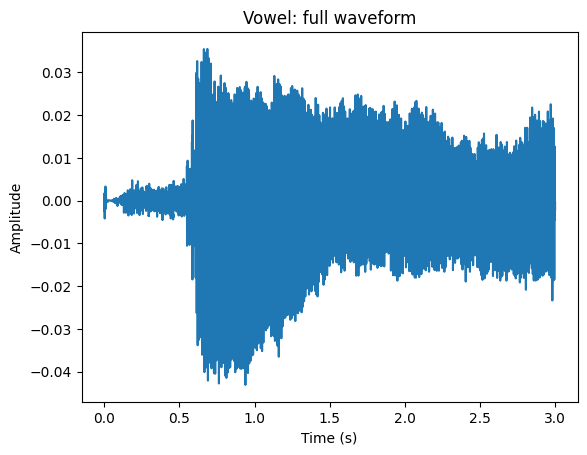

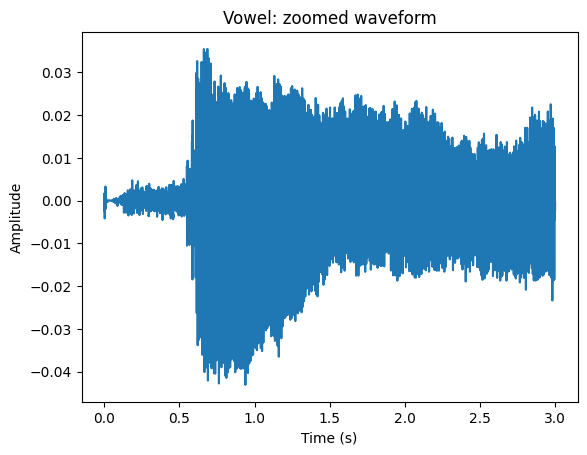

In [30]:
# TODO: Plot and play vowel
plot_waveform(x_vowel, fs_vowel, "Vowel: full waveform")
plot_waveform(x_vowel, fs_vowel, "Vowel: zoomed waveform", tlim=(..., ...))
play_audio(x_vowel, fs_vowel)


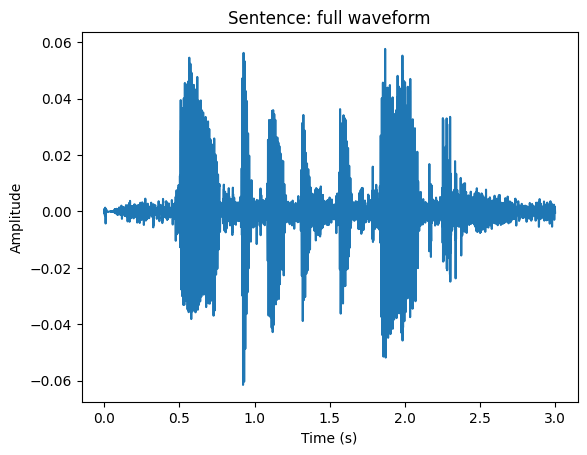

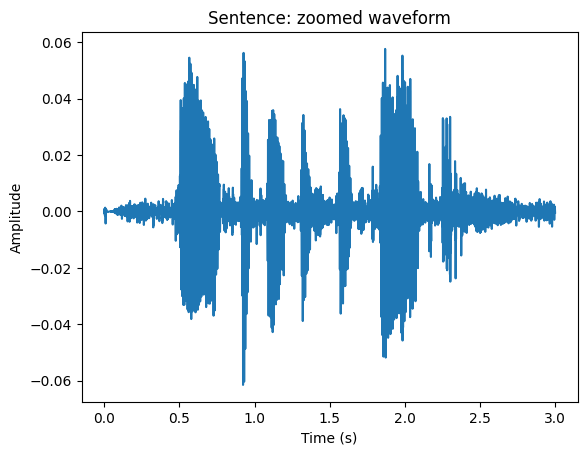

In [31]:
# TODO: Plot and play sentence
plot_waveform(x_sentence, fs_sentence, "Sentence: full waveform")
plot_waveform(x_sentence, fs_sentence, "Sentence: zoomed waveform", tlim=(..., ...))
play_audio(x_sentence, fs_sentence)


### Observations (Recording Quality)

Answer briefly (3–6 bullets total):

- Is the waveform symmetric around 0? What might cause asymmetry?
    Yes it is symmetric. I think that certain sounds can lead to asymmetry
- Are there visible silent regions? Where?
    Yes in the beginning and the end of the words
- Do you see any evidence of clipping (flat tops / bottoms)?
    No I do not see any evidence of clipping.
- Compare vowel vs sentence: what differences do you observe in amplitude dynamics?
    I see a better frequence compared to the vowel. The sentence seems to have more noticable frequency. 

---

# 2. Sampling Rate Experiments (Perceptual + Visual)

You will analyze how **sampling frequency** affects speech. Create resampled versions of **one** chosen signal first (recommended: the sentence), then optionally repeat for the vowel.

### Required target sampling rates
- Original sampling rate (reference)
- 16 kHz
- 8 kHz
- 4 kHz

> Use **proper resampling** (anti-aliasing filter + resample), not naive decimation.


In [32]:
# TODO: Choose which signal to use for sampling experiments
# Suggested: sentence
x_ref = x_sentence   # e.g., x_sentence
fs_ref = fs_sentence  # e.g., fs_sentence


In [ ]:
# TODO: Implement resampling utility
# Requirements:
# - Accept x, fs_in, fs_out
# - Return x_out (float in [-1, 1]) and fs_out

def resample_signal(x, fs_in, fs_out):
    raise NotImplementedError("Implement resample_signal")


In [ ]:
# TODO: Create resampled versions at 16k, 8k, 4k
# Store them in a dictionary for convenience.

target_fs_list = [16000, 8000, 4000]
signals = {}  # e.g., {"orig": (x_ref, fs_ref), "16k": (...), ...}

# signals["orig"] = (x_ref, fs_ref)
# for fs_tgt in target_fs_list:
#     x_tgt = resample_signal(x_ref, fs_ref, fs_tgt)
#     signals[f"{fs_tgt//1000}k"] = (x_tgt, fs_tgt)


## 2.1 Time-domain comparison

For each sampling rate:
- Plot the **same time segment** (same start time and duration in seconds)
- Use the **same y-limits** across plots if possible (helps comparison)


In [ ]:
# TODO: Plot the same segment for each sampling rate
# Choose a segment with speech activity (not silence).
# Example:
# segment_start = 0.5  # seconds
# segment_dur = 0.2    # seconds
# for key, (x, fs) in signals.items():
#     plot_waveform(x, fs, f"{key}: waveform segment", tlim=(segment_start, segment_start + segment_dur))


## 2.2 Frequency-domain comparison

For each sampling rate:
- Compute magnitude spectrum (FFT) for the **same segment length in seconds**
- Plot magnitude vs frequency (Hz)
- Use consistent plotting choices so the comparison is meaningful

### Hint (recommended approach)
- Apply a window (e.g., Hann) before FFT
- Plot only up to Nyquist (fs/2)


In [ ]:
# TODO: Implement FFT magnitude spectrum helper
def magnitude_spectrum(x, fs):
    """Return frequency axis (Hz) and magnitude spectrum (linear or dB)."""
    raise NotImplementedError("Implement magnitude_spectrum")


In [ ]:
# TODO: Plot spectra for each sampling rate
# for key, (x, fs) in signals.items():
#     f, mag = magnitude_spectrum(...)
#     plt.figure()
#     plt.plot(f, mag)
#     plt.title(...)
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude (dB)" or "Magnitude")
#     plt.xlim(0, fs/2)
#     plt.grid(True)
#     plt.show()


### Observations (Sampling)

Answer in 6–10 lines total:

- At what sampling rate does intelligibility begin to degrade (for your chosen signal)?
- Where do you visually observe aliasing (if at all)? What plot made it obvious?
- Does aliasing appear before or after speech becomes unintelligible?
- Does the vowel degrade differently than the sentence? Why might that be?


### Conceptual Reasoning (Sampling)

Answer clearly in complete sentences:

1. What is the **minimum sampling rate** you would recommend for intelligible speech?  
2. Does the Nyquist criterion alone guarantee **perceptual** quality? Explain.  
3. Why does speech remain intelligible even when high frequencies are lost? (Connect to speech cues.)


---

# 3. Quantization Experiments

You will study **bit depth** and its perceptual impact.

### Task
Quantize the *same reference signal* to:
- 16-bit (reference)
- 8-bit
- 4-bit
- 2-bit

> Implement **uniform quantization** yourself (do not call a pre-made quantizer).


In [ ]:
# TODO: Implement uniform quantization
# Requirements:
# - Input: x in [-1, 1]
# - Parameter: n_bits (e.g., 16, 8, 4, 2)
# - Output: quantized signal x_q in [-1, 1]
# - Also return quantization step size Δ (optional but recommended)

def uniform_quantize(x, n_bits):
    raise NotImplementedError("Implement uniform_quantize")


In [ ]:
# TODO: Generate quantized versions
# q_versions = {}
# for n_bits in [16, 8, 4, 2]:
#     x_q = uniform_quantize(x_ref, n_bits)
#     q_versions[f"{n_bits}bit"] = x_q


## 3.1 Quantized waveforms (zoom)

- Plot original vs quantized for a **50–100 ms** segment
- Overlay plots or show separate plots (your choice)
- Label clearly with bit depth


In [ ]:
# TODO: Plot original vs quantized signals (zoomed)
# tlim = ( ..., ... )
# plot_waveform(x_ref, fs_ref, "Original (reference)", tlim=tlim)
# for key, x_q in q_versions.items():
#     plot_waveform(x_q, fs_ref, f"Quantized: {key}", tlim=tlim)


## 3.2 Quantization error

Compute and visualize quantization error:
- error = original - quantized
- Plot error for a short segment
- (Optional) plot histogram of error values


In [ ]:
# TODO: Compute and plot quantization error
# for key, x_q in q_versions.items():
#     err = x_ref - x_q
#     ... plot err ...


## 3.3 Listening test

For each quantized version:
- Play audio inline
- Write 1–2 lines describing what you hear

> Tip: Use headphones for low-bit-depth signals.


In [ ]:
# TODO: Play quantized audio versions
# for key, x_q in q_versions.items():
#     print(key)
#     play_audio(x_q, fs_ref)


### Observations (Quantization)

Answer in 6–10 lines total:

- Which bit depth introduces clearly audible distortion first?
- Is distortion more noticeable in vowels or fricatives? Why?
- Does increasing sampling rate reduce quantization artifacts? Why or why not?


### Conceptual Reasoning (Quantization)

Answer clearly:

1. Why does quantization noise sound different from additive white noise?  
2. Why is speech surprisingly robust to low bit depth (to a point)?  
3. How is quantization related to dynamic range and SNR?


---

# 4. Sampling vs Quantization — Combined Effects

Compare the following two degradation types:

1. **High sampling + low bit depth** (e.g., 16 kHz at 2-bit or 4-bit)  
2. **Low sampling + high bit depth** (e.g., 4 kHz at 16-bit)

### Task
Create two or more paired conditions and evaluate:
- Waveform (zoom)
- Spectrum
- Listening


In [ ]:
# TODO: Build combined conditions (choose at least two comparisons)
# Example conditions:
# - (16k, 4-bit) vs (4k, 16-bit)
# - (16k, 2-bit) vs (8k, 16-bit)
#
# You may need to:
# - resample first, then quantize (or vice versa)
# - be consistent and document your pipeline


### Observations (Combined Effects)

Answer in 6–10 lines total:

- Which degradation is more perceptually damaging for your signal?
- Under what conditions does quantization dominate?
- Under what conditions does sampling dominate?
- Give one example from your plots that supports your conclusion.


### Final Conceptual Insight (Combined)

Explain (8–12 lines):

Why do **sampling frequency** and **quantization resolution** affect *different perceptual dimensions* of speech?

Use your own experiment results as evidence (point to specific plots or conditions).


---

# 5. Reflection (Mandatory)

Write thoughtful answers. There are no “right” responses here—only honest reflection.

### Reflection prompts
1. **What did you learn** that you did not understand before doing the experiments?  
2. What was a **sudden surprise / unexpected result** you noticed (visual or perceptual)?  
3. What was one moment where you thought you understood something, but the plots/audio **challenged your intuition**?  
4. If you had to explain sampling vs quantization to a friend in **two sentences**, what would you say?  
5. What is one question you now have that you want to explore further?


---

# 6. AI Use Disclosure (Required)

If you used any AI tools (including ChatGPT), briefly describe:
- What you used it for (e.g., debugging, concept clarification)
- What you wrote/changed yourself

Example:
- “Used ChatGPT to understand how resampling works conceptually; wrote resampling code myself.”

*(If you did not use AI, write “No AI tools used.”)*
